In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error, amplitude_damping_error
import matplotlib.colors as mcolors

# Constants
N_QUBITS = 200  # Number of qubits for statistical analysis
SHOTS = 1  # Single shot per qubit
print("Libraries imported successfully!")

/var/folders/x6/c44jk2f54jl2th8706q9sv500000gn/T/ipykernel_5650/3293833145.py:3: DeprecationWarning: Using Qiskit with Python 3.9 is deprecated as of the 2.1.0 release. Support for running Qiskit with Python 3.9 will be removed in the 2.3.0 release, which coincides with when Python 3.9 goes end of life.
  from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister


Libraries imported successfully!


In [2]:
def get_bit_flip_noise(p_noise):
    """Returns NoiseModel for bit flip (X) error on 'id' gate."""
    if p_noise <= 0:
        return None
    error = pauli_error([('X', p_noise), ('I', 1 - p_noise)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])
    return noise_model

def get_depolarizing_noise(p_noise):
    """Returns NoiseModel for depolarizing error on 'id' gate."""
    if p_noise <= 0:
        return None
    error = depolarizing_error(p_noise, 1)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])
    return noise_model

def get_amplitude_damping_noise(p_noise):
    """Returns NoiseModel for amplitude damping error on 'id' gate."""
    if p_noise <= 0:
        return None
    error = amplitude_damping_error(p_noise)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])
    return noise_model

def get_bit_phase_flip_noise(p_noise):
    """Returns NoiseModel for combined bit and phase flip (Y) error on 'id' gate."""
    if p_noise <= 0:
        return None
    error = pauli_error([('Y', p_noise), ('I', 1 - p_noise)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])
    return noise_model

print("Noise model functions defined!")

Noise model functions defined!


Standard circuit (no QZE):


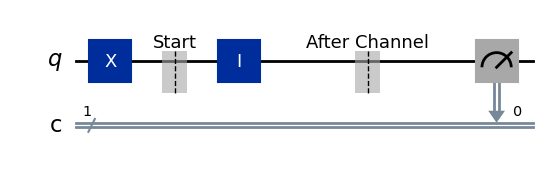

In [3]:
def build_standard_noisy_circuit(initial_state):
    """
    Builds a circuit with a qubit traveling through a noisy channel.
    initial_state: 0 or 1 (the bit we want to transmit)
    """
    qr = QuantumRegister(1, 'q')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Prepare initial state
    if initial_state == 1:
        qc.x(0)
    qc.barrier(label='Start')
    
    # Noisy channel - single id gate where noise is applied
    qc.id(0)
    qc.barrier(label='After Channel')
    
    # Measurement
    qc.measure(0, 0)
    
    return qc

# Create example circuit for visualization
example_circuit = build_standard_noisy_circuit(1)
print("Standard circuit (no QZE):")
display(example_circuit.draw('mpl'))



QZE-protected circuit (5 measurements):


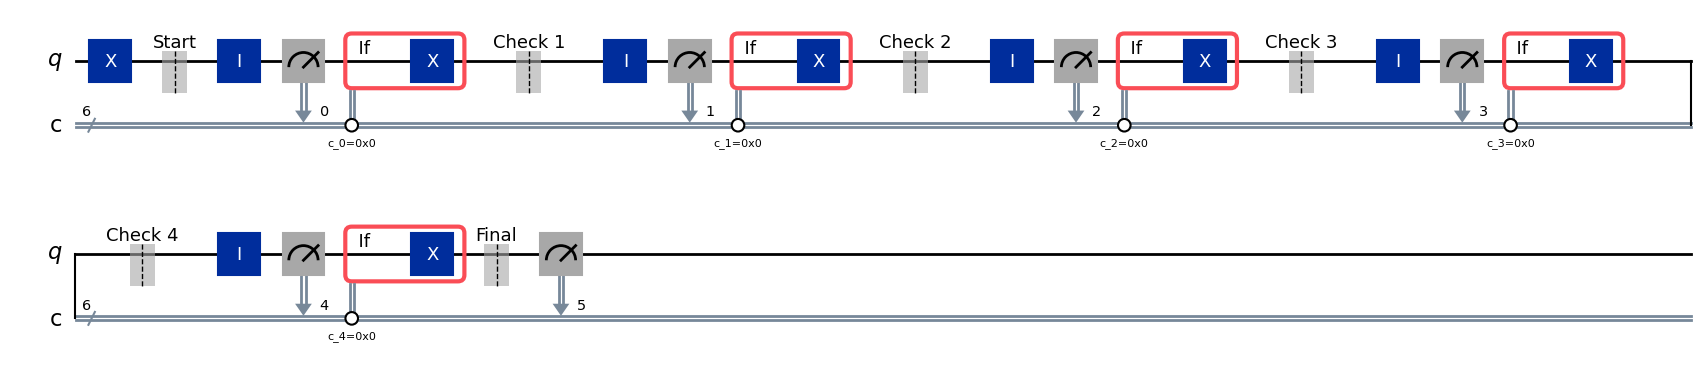

In [4]:
def build_qze_protected_circuit(initial_state, n_measurements):
    """
    Builds a circuit with QZE protection via frequent measurements.
    initial_state: 0 or 1
    n_measurements: number of measurement steps during transmission
    """
    qr = QuantumRegister(1, 'q')
    cr = ClassicalRegister(n_measurements + 1, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Prepare initial state
    if initial_state == 1:
        qc.x(0)
    qc.barrier(label='Start')
    
    # QZE: Divide channel into segments with measurements
    for i in range(n_measurements):
        qc.id(0)  # Noisy channel segment
        qc.measure(0, i)  # Zeno measurement
        
        # Correction: If measurement shows wrong state, flip it back
        with qc.if_test((cr[i], initial_state ^ 1)):
            qc.x(0)
        
        if i < n_measurements - 1:
            qc.barrier(label=f'Check {i+1}')
    
    qc.barrier(label='Final')
    qc.measure(0, n_measurements)
    
    return qc

# Create example QZE circuit for visualization
example_qze_circuit = build_qze_protected_circuit(1, 5)
print("\nQZE-protected circuit (5 measurements):")
display(example_qze_circuit.draw('mpl'))

In [5]:
def build_qze_simple_circuit(initial_state, n_steps):
    """
    Simplified QZE circuit for efficient simulation.
    Applies partial noise at each step with implicit projection.
    """
    qr = QuantumRegister(1, 'q')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Prepare initial state
    if initial_state == 1:
        qc.x(0)
    qc.barrier(label='Start')
    
    # Divide channel into n_steps segments
    for i in range(n_steps):
        qc.id(0)  # Each id gate gets fraction of total noise
        if i < n_steps - 1:
            qc.barrier(label=f'Step {i+1}')
    
    qc.barrier(label='End')
    qc.measure(0, 0)
    
    return qc

print("\nSimplified QZE circuit functions defined!")


Simplified QZE circuit functions defined!


In [6]:
def run_standard_channel(n_qubits, initial_state, p_noise, noise_type='bit_flip'):
    """
    Simulate standard noisy channel without QZE protection.
    Returns bit error rate.
    """
    # Get noise model
    noise_model_map = {
        'bit_flip': get_bit_flip_noise,
        'depolarizing': get_depolarizing_noise,
        'amplitude_damping': get_amplitude_damping_noise,
        'bit_phase_flip': get_bit_phase_flip_noise
    }
    
    noise_model = noise_model_map[noise_type](p_noise)
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    
    errors = 0
    for _ in range(n_qubits):
        qc = build_standard_noisy_circuit(initial_state)
        job = simulator.run(qc, shots=1, memory=True)
        result = job.result()
        measured_bit = int(result.get_memory()[0])
        
        if measured_bit != initial_state:
            errors += 1
    
    error_rate = errors / n_qubits
    return error_rate

print("Standard channel simulation function defined!")


Standard channel simulation function defined!


In [7]:
def run_qze_channel(n_qubits, initial_state, p_noise, n_steps, noise_type='bit_flip'):
    """
    Simulate QZE-protected channel.
    Noise is divided across n_steps segments.
    Returns bit error rate.
    """
    # Divide total noise across steps
    p_step = p_noise / max(1, n_steps)
    
    # Get noise model with reduced per-step noise
    noise_model_map = {
        'bit_flip': get_bit_flip_noise,
        'depolarizing': get_depolarizing_noise,
        'amplitude_damping': get_amplitude_damping_noise,
        'bit_phase_flip': get_bit_phase_flip_noise
    }
    
    noise_model = noise_model_map[noise_type](p_step)
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    
    errors = 0
    for _ in range(n_qubits):
        qc = build_qze_simple_circuit(initial_state, n_steps)
        job = simulator.run(qc, shots=1, memory=True)
        result = job.result()
        measured_bit = int(result.get_memory()[0])
        
        if measured_bit != initial_state:
            errors += 1
    
    error_rate = errors / n_qubits
    return error_rate

print("QZE channel simulation function defined!")


QZE channel simulation function defined!


Running standard channel simulations (N=200)...
  Simulating bit_flip...
  Simulating depolarizing...
  Simulating amplitude_damping...
  Simulating bit_phase_flip...
Standard simulations complete!


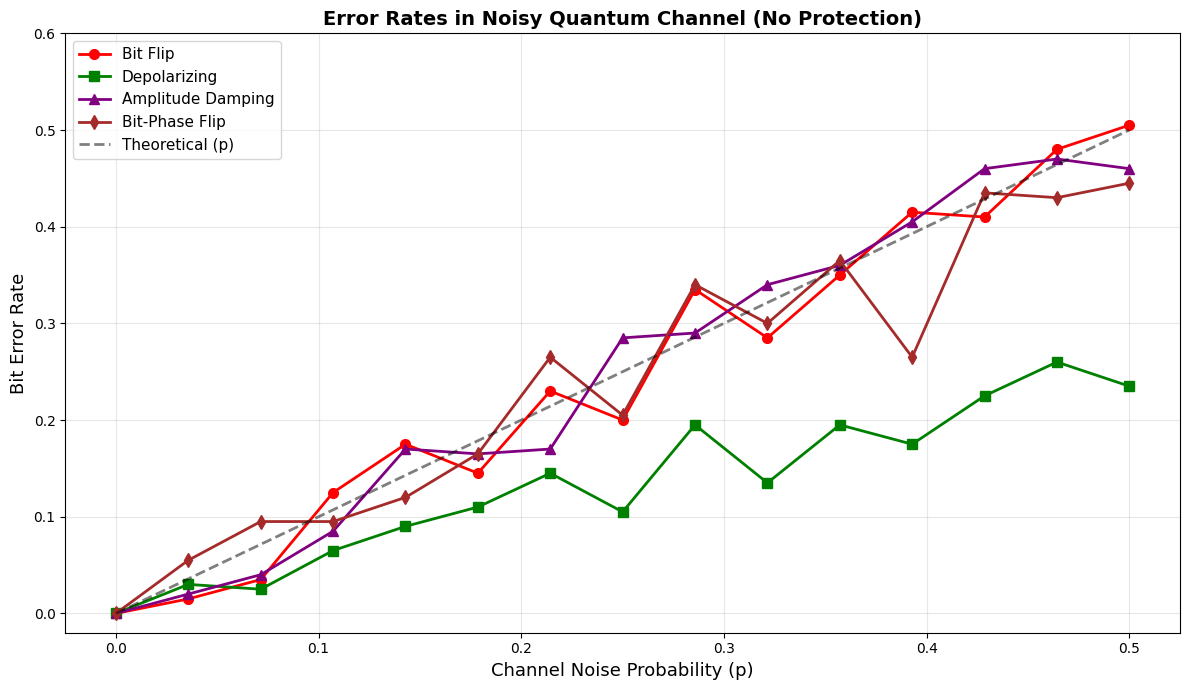

In [8]:
noise_levels = np.linspace(0, 0.5, 15)
initial_state = 1  # Transmitting |1⟩ state

# Store results for all noise types
noise_types = ['bit_flip', 'depolarizing', 'amplitude_damping', 'bit_phase_flip']
error_rates_std = {nt: [] for nt in noise_types}

print(f"Running standard channel simulations (N={N_QUBITS})...")

for noise_type in noise_types:
    print(f"  Simulating {noise_type}...")
    for p in noise_levels:
        er = run_standard_channel(N_QUBITS, initial_state, p, noise_type)
        error_rates_std[noise_type].append(er)

print("Standard simulations complete!")

# Plot single combined graph
plt.figure(figsize=(12, 7))

colors = ['red', 'green', 'purple', 'brown']
markers = ['o', 's', '^', 'd']
titles = ['Bit Flip', 'Depolarizing', 'Amplitude Damping', 'Bit-Phase Flip']

for noise_type, color, marker, title in zip(noise_types, colors, markers, titles):
    plt.plot(noise_levels, error_rates_std[noise_type], 
             marker=marker, linestyle='-', label=title, 
             color=color, linewidth=2, markersize=7)

plt.plot(noise_levels, noise_levels, 'k--', label='Theoretical (p)', alpha=0.5, linewidth=2)
plt.xlabel('Channel Noise Probability (p)', fontsize=13)
plt.ylabel('Bit Error Rate', fontsize=13)
plt.title('Error Rates in Noisy Quantum Channel (No Protection)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.ylim(-0.02, 0.6)
plt.tight_layout()
plt.show()

Running comparison simulations (N=200, QZE steps=10)...
  Simulating bit_flip...
  Simulating depolarizing...
  Simulating amplitude_damping...
  Simulating bit_phase_flip...
Comparison simulations complete!


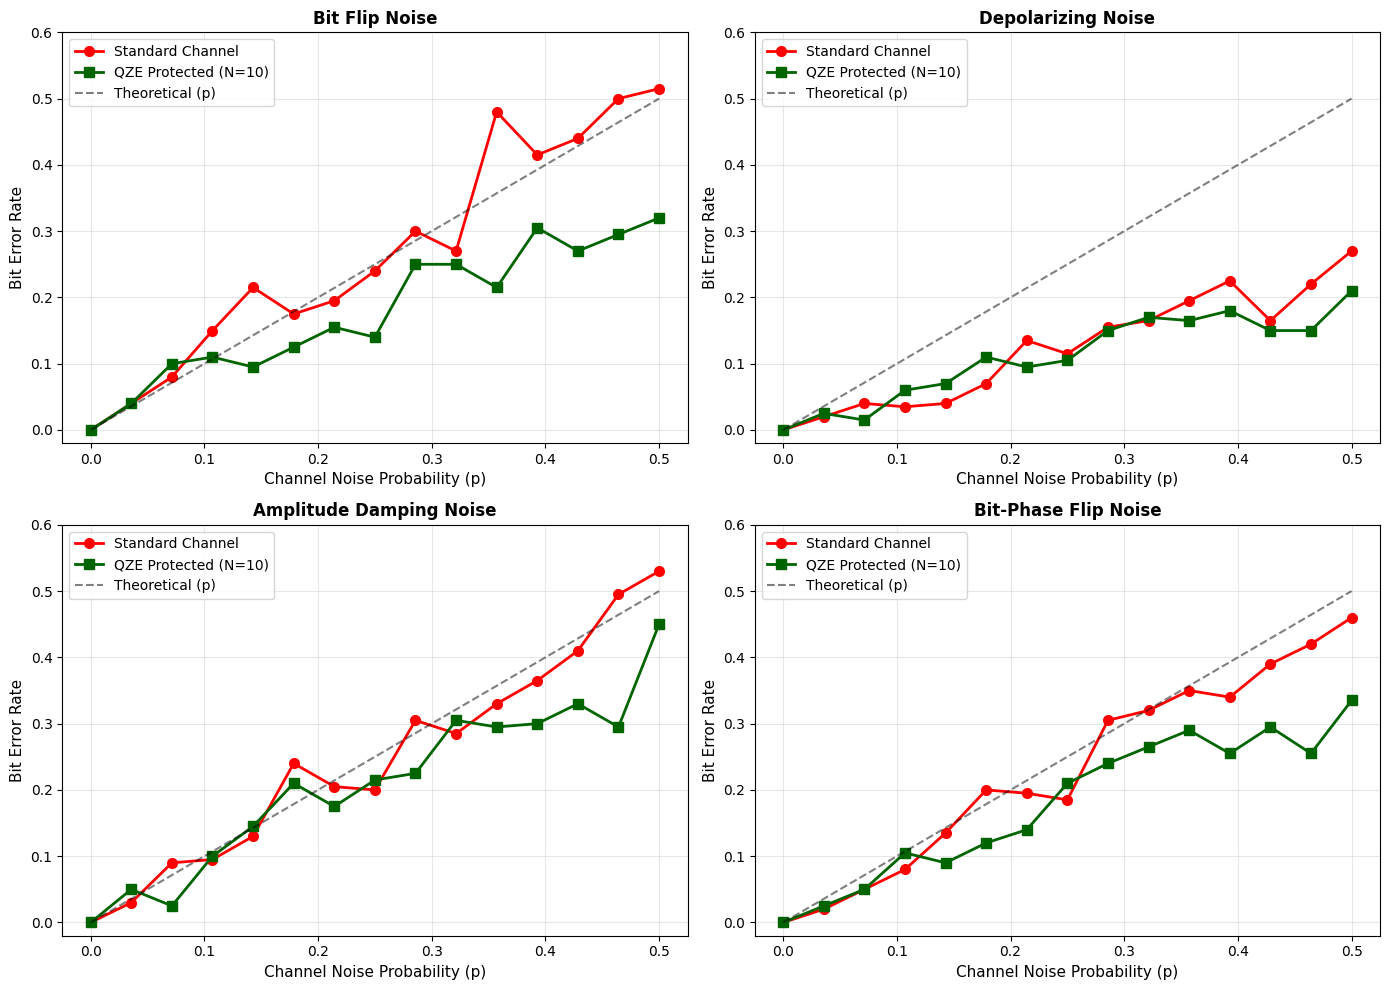

In [9]:
n_measurements_fixed = 10
noise_levels_comp = np.linspace(0, 0.5, 15)

# Run simulations for all noise types
results_comp = {nt: {'std': [], 'qze': []} for nt in noise_types}

print(f"Running comparison simulations (N={N_QUBITS}, QZE steps={n_measurements_fixed})...")

for noise_type in noise_types:
    print(f"  Simulating {noise_type}...")
    for p in noise_levels_comp:
        # Standard
        er_std = run_standard_channel(N_QUBITS, initial_state, p, noise_type)
        results_comp[noise_type]['std'].append(er_std)
        
        # QZE protected
        er_qze = run_qze_channel(N_QUBITS, initial_state, p, n_measurements_fixed, noise_type)
        results_comp[noise_type]['qze'].append(er_qze)

print("Comparison simulations complete!")

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (noise_type, color, title) in enumerate(zip(noise_types, colors, titles)):
    ax = axes[idx]
    ax.plot(noise_levels_comp, results_comp[noise_type]['std'], 'o-', 
            label='Standard Channel', color='red', linewidth=2, markersize=7)
    ax.plot(noise_levels_comp, results_comp[noise_type]['qze'], 's-', 
            label=f'QZE Protected (N={n_measurements_fixed})', 
            color='darkgreen', linewidth=2, markersize=7)
    ax.plot(noise_levels_comp, noise_levels_comp, 'k--', label='Theoretical (p)', alpha=0.5)
    ax.set_xlabel('Channel Noise Probability (p)', fontsize=11)
    ax.set_ylabel('Bit Error Rate', fontsize=11)
    ax.set_title(f'{title} Noise', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.02, 0.6)

plt.tight_layout()
plt.show()


Running frequency analysis (N=200)...
  Noise level p=0.1...
  Noise level p=0.2...
  Noise level p=0.3...
  Noise level p=0.4...
Frequency analysis complete!


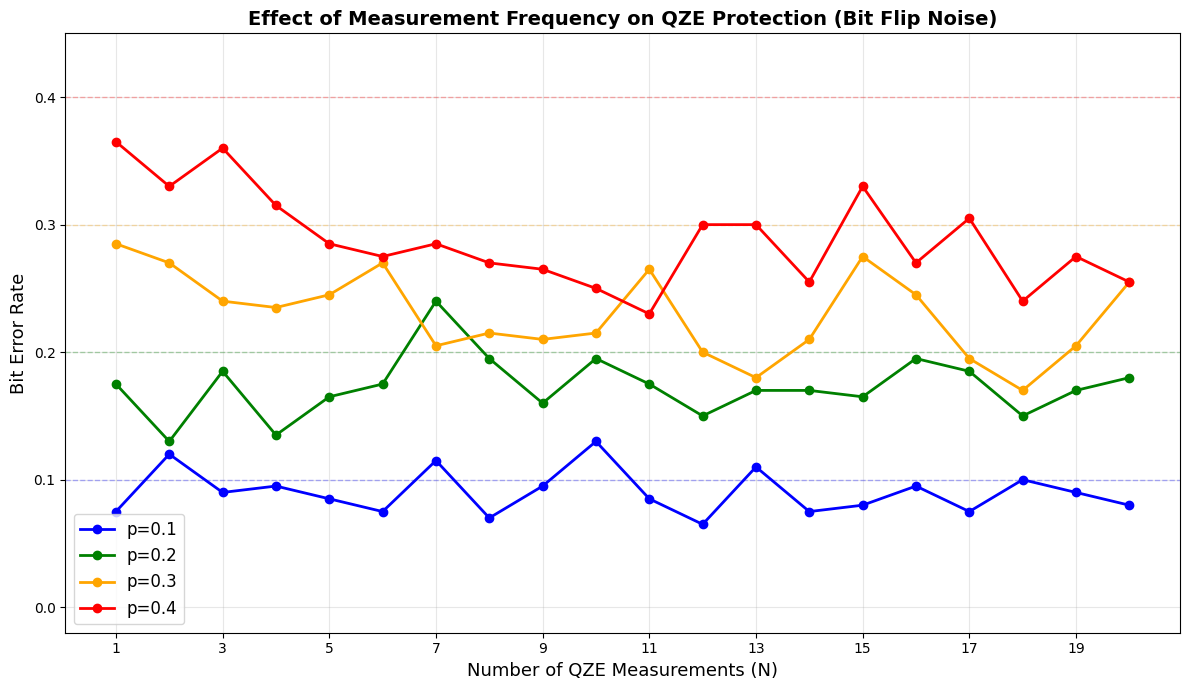

In [10]:
measurement_steps_range = np.arange(1, 21, 1)  # 1 to 20 measurements (whole numbers)
noise_levels_freq = [0.1, 0.2, 0.3, 0.4]

# Run for bit flip noise
error_rates_vs_freq = {p: [] for p in noise_levels_freq}

print(f"Running frequency analysis (N={N_QUBITS})...")

for p in noise_levels_freq:
    print(f"  Noise level p={p}...")
    for n_steps in measurement_steps_range:
        er = run_qze_channel(N_QUBITS, initial_state, p, int(n_steps), 'bit_flip')
        error_rates_vs_freq[p].append(er)

print("Frequency analysis complete!")

# Plot
plt.figure(figsize=(12, 7))
colors_freq = ['blue', 'green', 'orange', 'red']
for i, p in enumerate(noise_levels_freq):
    plt.plot(measurement_steps_range, error_rates_vs_freq[p], 'o-', 
             label=f'p={p}', color=colors_freq[i], linewidth=2, markersize=6)
    plt.axhline(y=p, color=colors_freq[i], linestyle='--', alpha=0.3, linewidth=1)

plt.xlabel('Number of QZE Measurements (N)', fontsize=13)
plt.ylabel('Bit Error Rate', fontsize=13)
plt.title('Effect of Measurement Frequency on QZE Protection (Bit Flip Noise)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(-0.02, 0.45)
plt.xticks(measurement_steps_range[::2])  # Show every other tick
plt.tight_layout()
plt.show()

Running fixed noise simulations (p=0.25, N=200)...
  Simulating bit_flip...
  Simulating depolarizing...
  Simulating amplitude_damping...
  Simulating bit_phase_flip...
Fixed noise simulations complete!


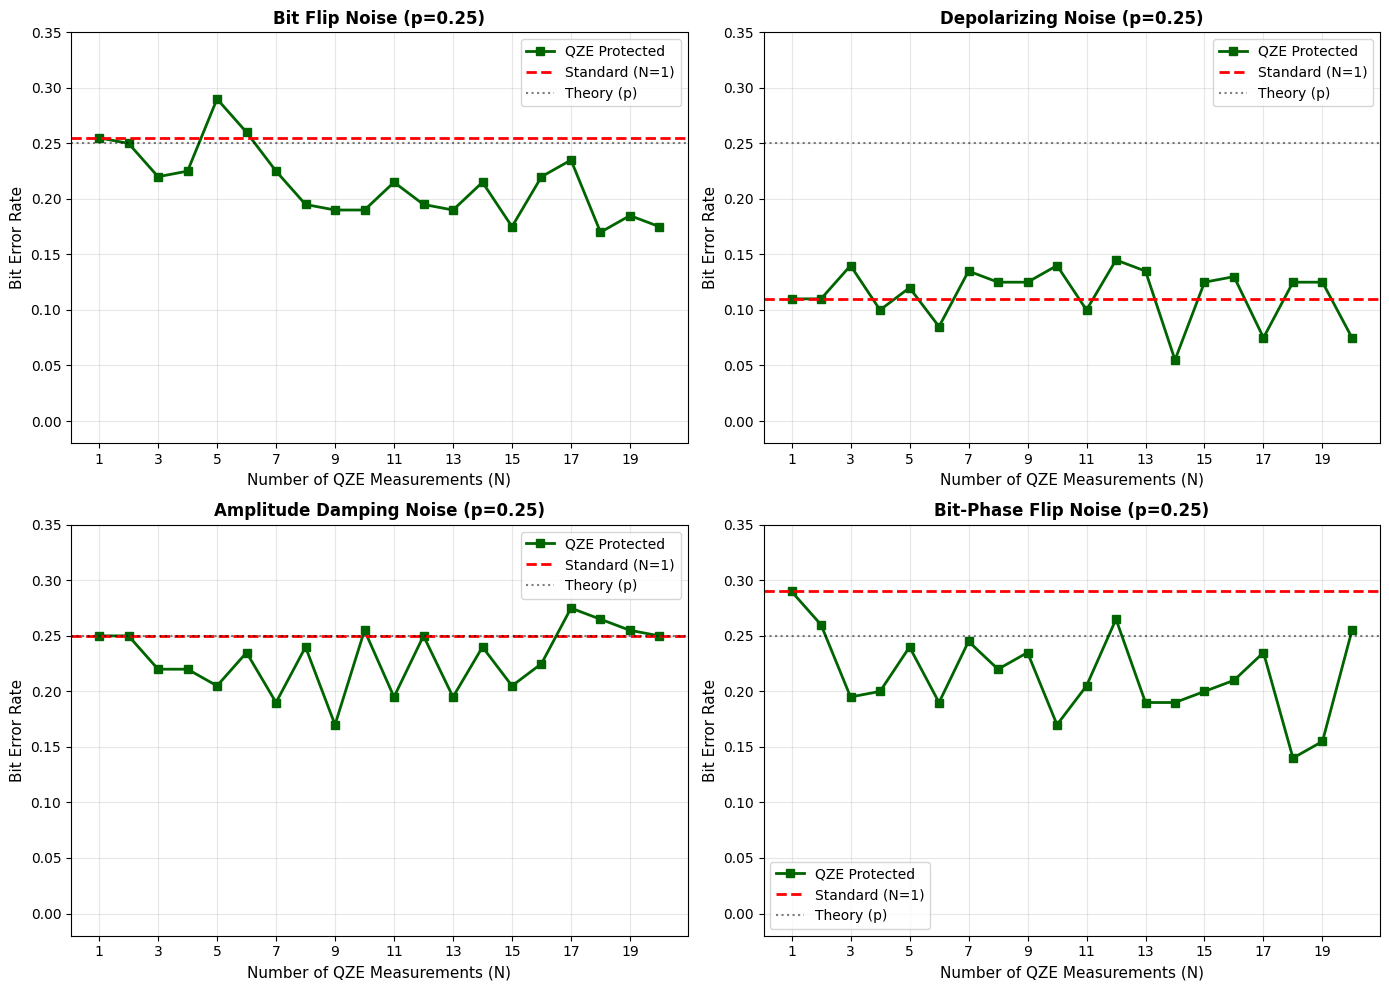

In [11]:
fixed_noise_level = 0.25
measurement_steps_fixed_noise = np.arange(1, 21, 1)  # Whole numbers only

error_rates_fixed_noise = {nt: [] for nt in noise_types}

print(f"Running fixed noise simulations (p={fixed_noise_level}, N={N_QUBITS})...")

for noise_type in noise_types:
    print(f"  Simulating {noise_type}...")
    for n_steps in measurement_steps_fixed_noise:
        er = run_qze_channel(N_QUBITS, initial_state, fixed_noise_level, int(n_steps), noise_type)
        error_rates_fixed_noise[noise_type].append(er)

print("Fixed noise simulations complete!")

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (noise_type, color, title) in enumerate(zip(noise_types, colors, titles)):
    ax = axes[idx]
    
    # QZE curve
    ax.plot(measurement_steps_fixed_noise, error_rates_fixed_noise[noise_type], 
            's-', color='darkgreen', label='QZE Protected', linewidth=2, markersize=6)
    
    # Standard (N=1) as horizontal line
    standard_error = error_rates_fixed_noise[noise_type][0]
    ax.axhline(y=standard_error, color='red', linestyle='--', 
               label=f'Standard (N=1)', linewidth=2)
    
    # Theoretical noise level
    ax.axhline(y=fixed_noise_level, color='black', linestyle=':', 
               label='Theory (p)', alpha=0.5)
    
    ax.set_xlabel('Number of QZE Measurements (N)', fontsize=11)
    ax.set_ylabel('Bit Error Rate', fontsize=11)
    ax.set_title(f'{title} Noise (p={fixed_noise_level})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(measurement_steps_fixed_noise[::2])
    ax.set_ylim(-0.02, max(standard_error * 1.2, 0.35))

plt.tight_layout()
plt.show()


Running heatmap simulations for bit_flip...
  bit_flip complete!
Running heatmap simulations for depolarizing...
  depolarizing complete!


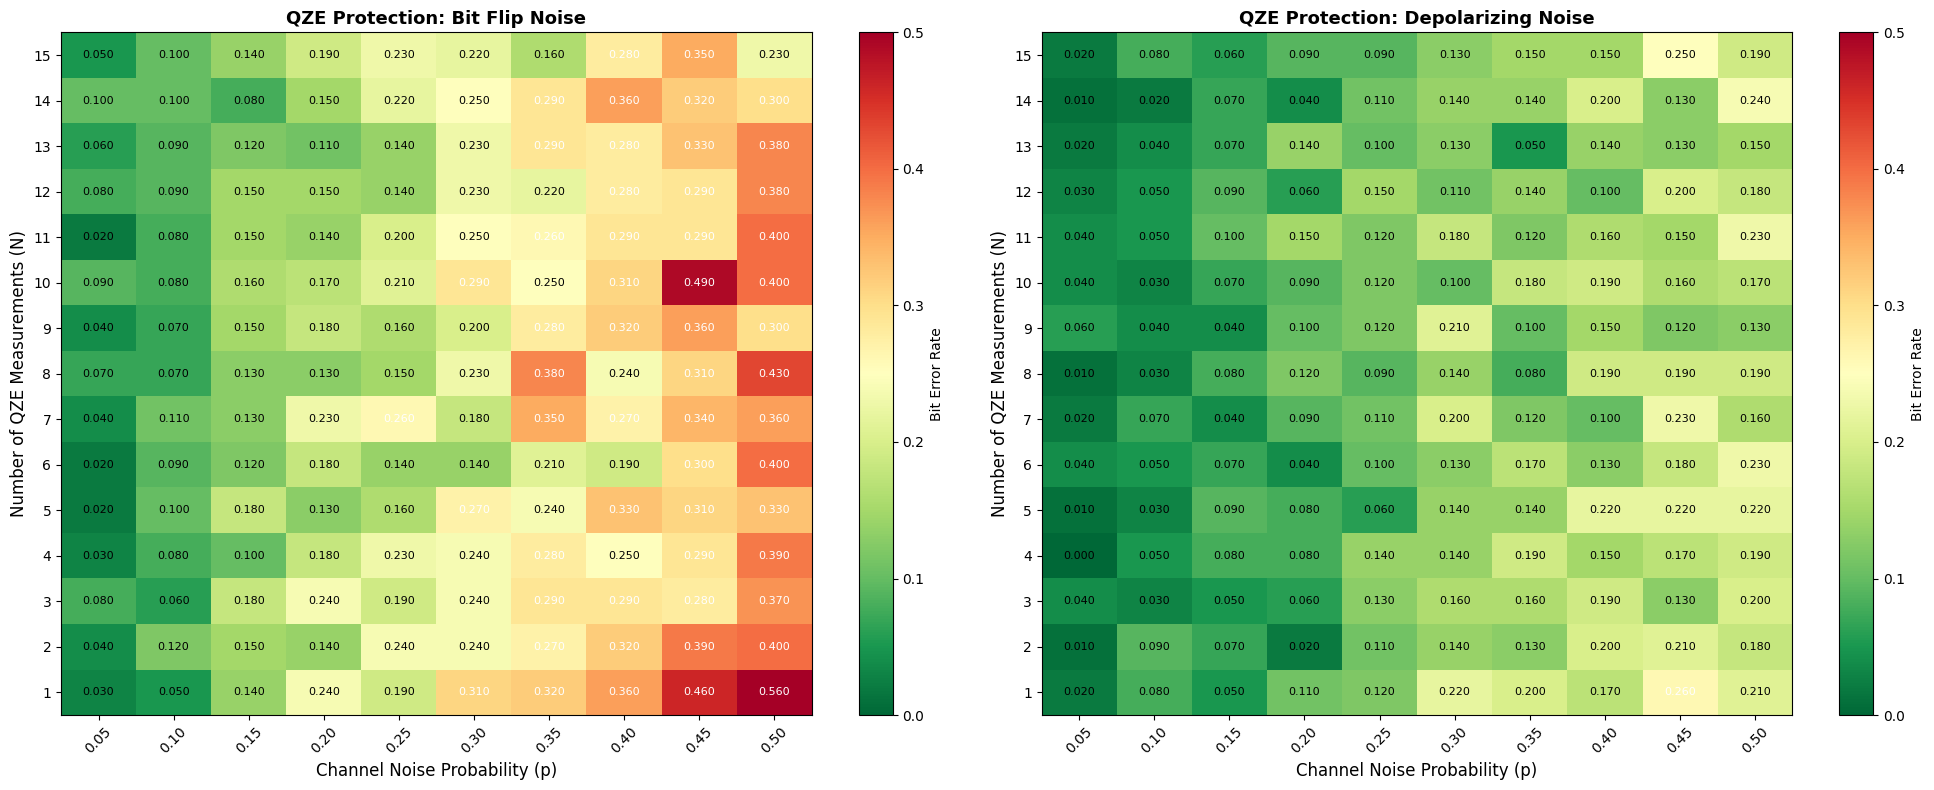

In [12]:
N_QUBITS_HEATMAP = 100
noise_levels_heat = np.linspace(0.05, 0.5, 10)
measurement_steps_heat = np.arange(1, 16, 1)  # Whole numbers

# Run for bit flip and depolarizing noise
heatmap_noise_types = ['bit_flip', 'depolarizing']
heatmap_titles = ['Bit Flip', 'Depolarizing']
error_grids = {}

for noise_type in heatmap_noise_types:
    print(f"Running heatmap simulations for {noise_type}...")
    error_grid = np.zeros((len(measurement_steps_heat), len(noise_levels_heat)))
    
    for i, n_steps in enumerate(measurement_steps_heat):
        for j, p in enumerate(noise_levels_heat):
            er = run_qze_channel(N_QUBITS_HEATMAP, initial_state, p, int(n_steps), noise_type)
            error_grid[i, j] = er
    
    error_grids[noise_type] = error_grid
    print(f"  {noise_type} complete!")

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for idx, (noise_type, title) in enumerate(zip(heatmap_noise_types, heatmap_titles)):
    ax = axes[idx]
    error_grid = error_grids[noise_type]
    
    dp = noise_levels_heat[1] - noise_levels_heat[0]
    extent = [noise_levels_heat[0] - dp/2, noise_levels_heat[-1] + dp/2,
              measurement_steps_heat[0] - 0.5, measurement_steps_heat[-1] + 0.5]
    
    norm = mcolors.Normalize(vmin=0, vmax=0.5)
    im = ax.imshow(error_grid, aspect='auto', interpolation='nearest',
                   origin='lower', cmap='RdYlGn_r', norm=norm, extent=extent)
    
    # Add text annotations
    for i in range(len(measurement_steps_heat)):
        for j in range(len(noise_levels_heat)):
            error = error_grid[i, j]
            text_color = "white" if error > 0.25 else "black"
            ax.text(noise_levels_heat[j], measurement_steps_heat[i],
                    f'{error:.3f}', ha='center', va='center',
                    color=text_color, fontsize=8)
    
    plt.colorbar(im, ax=ax, label='Bit Error Rate')
    ax.set_xlabel('Channel Noise Probability (p)', fontsize=12)
    ax.set_ylabel('Number of QZE Measurements (N)', fontsize=12)
    ax.set_title(f'QZE Protection: {title} Noise', fontsize=13, fontweight='bold')
    ax.set_xticks(noise_levels_heat)
    ax.set_xticklabels([f'{p:.2f}' for p in noise_levels_heat], rotation=45)
    ax.set_yticks(measurement_steps_heat)

plt.tight_layout()
plt.show()

In [14]:
import numpy as np

print("=" * 80)
print("SUMMARY: QZE Protection Against Channel Noise (Averaged Results)")
print("=" * 80)

# --- Configuration ---
test_noise = 0.25          # Probability of error (p)
test_steps = 10            # Number of QZE measurements (N)
num_trials = 20            # Number of times to repeat the experiment for averaging
titles_summary = ['Bit Flip', 'Depolarizing', 'Amplitude Damping', 'Bit-Phase Flip']

print(f"\nTest Case: p={test_noise}, N={test_steps} measurements")
print(f"Statistics: Averaged over {num_trials} independent trials per noise type")
print("-" * 80)
print(f"{'Noise Type':<20} {'Avg Standard':<15} {'Avg QZE':<15} {'Avg Improvement':<15}")
print("-" * 80)

# Iterate through each noise type
for noise_type, title in zip(noise_types, titles_summary):
    std_ber_list = []
    qze_ber_list = []
    
    # Run the simulation multiple times to get an average
    for _ in range(num_trials):
        # Run Standard Channel
        er_std = run_standard_channel(100, initial_state, test_noise, noise_type)
        std_ber_list.append(er_std)
        
        # Run QZE Protected Channel
        er_qze = run_qze_channel(100, initial_state, test_noise, test_steps, noise_type)
        qze_ber_list.append(er_qze)
    
    # Calculate Mean BERs
    avg_std = np.mean(std_ber_list)
    avg_qze = np.mean(qze_ber_list)
    
    # Calculate Improvement Percentage
    if avg_std > 0:
        improvement = (avg_std - avg_qze) / avg_std * 100
    else:
        improvement = 0.0
    
    # Print row
    print(f"{title:<20} {avg_std:.4f}          {avg_qze:.4f}          {improvement:>6.1f}%")

print("-" * 80)

SUMMARY: QZE Protection Against Channel Noise (Averaged Results)

Test Case: p=0.25, N=10 measurements
Statistics: Averaged over 20 independent trials per noise type
--------------------------------------------------------------------------------
Noise Type           Avg Standard    Avg QZE         Avg Improvement
--------------------------------------------------------------------------------
Bit Flip             0.2475          0.2105            14.9%
Depolarizing         0.1195          0.1120             6.3%
Amplitude Damping    0.2715          0.2380            12.3%
Bit-Phase Flip       0.2680          0.2100            21.6%
--------------------------------------------------------------------------------
